Current Working Directory: progettoVIPM


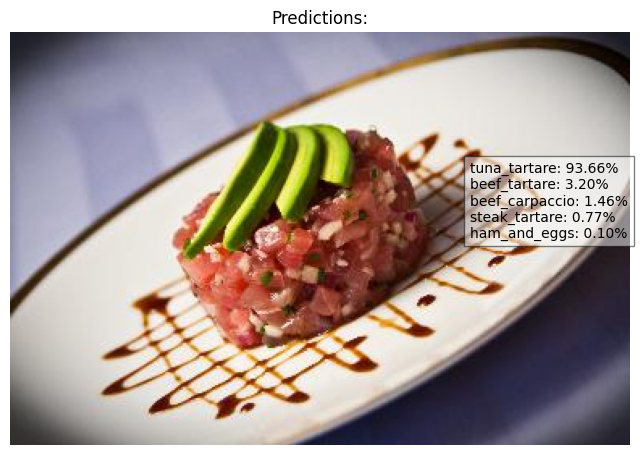

In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')



# Load class names
def load_classes(class_file):
    classes = {}
    with open(class_file, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            classes[int(row[0])] = row[1]
    return classes

# Preprocess image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.6354, 0.5413, 0.4419], std=[0.2760, 0.2900, 0.3161]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

# Load model
def load_model(model_path, device):
    model = models.resnet50()
    num_classes = 251
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = torch.load(model_path)
    model.to("cpu")
    return model

# Predict top 5 classes
def predict(model, image_tensor, classes, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        top5_prob, top5_catid = torch.topk(probabilities, 5)
    return [(classes.get(i.item(), "Unknown"), prob.item()) for i, prob in zip(top5_catid, top5_prob)]

# Display image with predictions
def display_image(image_path, predictions):
    image = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title("Predictions:")
    
    text = "\n".join([f"{label}: {prob:.2%}" for label, prob in predictions])
    plt.figtext(0.7, 0.5, text, wrap=True, horizontalalignment='left', fontsize=10, bbox={"facecolor": "white", "alpha": 0.5})
    plt.show()

if __name__ == "__main__":
    
    if(os.path.split(os.getcwd())[1] == "misc"):
        os.chdir("..")
    print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))
    image_path = "train_set/train_003539.jpg"  # Change to your image file
    model_path = "Transfer_Learning/models/finetunedResNet50_minusnessuno_10e_64bsize_80_20_split_dataset_degraded_train_whole.pth"  # Change to your model file
    class_file = "disambiguation.csv"  # Change to your class names file

    device = "cpu"
    
    classes = load_classes(class_file)
    image_tensor = preprocess_image(image_path)
    model = load_model(model_path, device)
    predictions = predict(model, image_tensor, classes, device)
    display_image(image_path, predictions)